## Modeling

In [1]:
%run functions_ml.ipynb

Importing main Libraries
Importing Metrics
Importing Mape
Improting human_format
Importing PrecioSplitter
Importing ClippedTarget


Using TensorFlow backend.
C:\Users\VoxivaAI\.conda\envs\aiforhealthcare\lib\site-packages\keras\callbacks\callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


El conjunto de datos contiene características principales de las aplicaciones en el mercado de Google Play Store. 

Definición de variables:

- ID  = Identificador único de la aplicación 
- App  = Nombre de la aplicación
- Category  =  Categoría de la aplicación 
- Reviews = Numero de reseñas de la aplicación 
- Size  = Tamaño de la aplicación 
- Installs  = Numero de descargas/instalaciones en el equipo
- Type = Gratis (Free) o Paid (Paga)
- Price  = Precio de la aplicación en dólares
- Content rating = Calificación de contenido
- Genres = Géneros
- Last Updated = Ultimo día de actualización 
- Current Ver = Versión actual de la aplicación 
- Android Ver = Versión de Android requerida
- Rating = Calificación de la aplicación 

La escala del Rating inicialmente de la forma (3.3, 3.4, 3.5, etc.), se transformó en 2 clases:

-0 si el Rating es menor o igual 4 (Rating <= 4.0) 
-1 si el Rating es mayor a 4 (Rating > 4.0) 

In [2]:
import xgboost as xgb 
import seaborn as sns
from datetime import date

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
from sklearn.svm import SVR
from xgboost import XGBClassifier
# from vecstack import stacking

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

C:\Users\VoxivaAI\.conda\envs\aiforhealthcare\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
dftrain = pd.read_csv("datasets/train.csv")
dftest = pd.read_csv("datasets/test.csv")
dfsample = pd.read_csv("datasets/sample.csv")

In [4]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5788 entries, 0 to 5787
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              5788 non-null   int64  
 1   App             5788 non-null   object 
 2   Category        5788 non-null   object 
 3   Rating          5788 non-null   float64
 4   Reviews         5788 non-null   int64  
 5   Size            5788 non-null   object 
 6   Installs        5788 non-null   object 
 7   Type            5788 non-null   object 
 8   Price           5788 non-null   object 
 9   Content Rating  5788 non-null   object 
 10  Genres          5788 non-null   object 
 11  Last Updated    5788 non-null   object 
 12  Current Ver     5788 non-null   object 
 13  Android Ver     5788 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 633.2+ KB


In [5]:
cols = dftrain.columns 
dftrain.columns = [i.lower().replace(" ", "_") for i in cols]

cols = dftest.columns
dftest.columns  = [i.lower().replace(" ", "_") for i in cols]

In [6]:
import re

def get_pattern(x, pattern):
    preresult = re.findall(pattern, x)
    
    if len(preresult) > 0:
        result = preresult[0]
        
    else:
        result = np.nan
        
    return result

def preprocess_data(data):
    data["size_num"]  = data["size"].apply(lambda x:   get_pattern(x, r"\d*\.?\d+"))
    data["size_name"] = data["size"].apply(lambda x:   get_pattern(x, r"[a-zA-Z]+"))
    data["size_name"] = data["size_name"].apply(lambda x: np.nan if x == "Varies"  else x)
    data["size_kb"] = data.apply(lambda x: float(x["size_num"])*1000 if x["size_name"] == "M" else x["size_num"], axis = 1)
    data["installs"] = data["installs"].apply(lambda x:   get_pattern(x.replace(",", ""), r"\d*\,?\d+"))
    data["android_version"] = data["android_ver"].apply(lambda x: get_pattern(x, r"\d*\.?\d*\.?\d+"))
    data["current_version"] = data["current_ver"].apply(lambda x: get_pattern(x, r"\d*\.?\d*\.?\d+"))
    data["main_version"] = data.apply(lambda x: 0 if pd.isnull(x["current_version"]) else str(x["current_version"]).split(".")[0], axis = 1)
    data["main_version"] = data["main_version"].fillna(0)
    
    data["app_version"] = data.apply(lambda x: 0 if pd.isnull(x["android_version"]) else str(x["android_version"]).split(".")[0], axis = 1)
    data["app_version"] = data["app_version"].fillna(0)
    
    data["latest_android_ver"] = 10
    data["price_float"] = data["price"].apply(lambda x: get_pattern(x, r"\d*\.?\d*\.?\d+"))
    data["last_updated_date"] = pd.to_datetime(data["last_updated"])
    data["size_kb"] = data["size_kb"].astype(float)
    data["price_float"] = data["price_float"].astype(float)
    return data


In [7]:
dftrain = preprocess_data(dftrain)
dftest = preprocess_data(dftest)

In [8]:
dftrain["rating"].value_counts()

1.000    4317
0.000    1471
Name: rating, dtype: int64

In [9]:
dftrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5788 entries, 0 to 5787
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  5788 non-null   int64         
 1   app                 5788 non-null   object        
 2   category            5788 non-null   object        
 3   rating              5788 non-null   float64       
 4   reviews             5788 non-null   int64         
 5   size                5788 non-null   object        
 6   installs            5788 non-null   object        
 7   type                5788 non-null   object        
 8   price               5788 non-null   object        
 9   content_rating      5788 non-null   object        
 10  genres              5788 non-null   object        
 11  last_updated        5788 non-null   object        
 12  current_ver         5788 non-null   object        
 13  android_ver         5788 non-null   object      

In [10]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1448 entries, 0 to 1447
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   id                  1448 non-null   int64         
 1   app                 1448 non-null   object        
 2   category            1448 non-null   object        
 3   reviews             1448 non-null   int64         
 4   size                1448 non-null   object        
 5   installs            1448 non-null   object        
 6   type                1448 non-null   object        
 7   price               1448 non-null   object        
 8   content_rating      1448 non-null   object        
 9   genres              1448 non-null   object        
 10  last_updated        1448 non-null   object        
 11  current_ver         1448 non-null   object        
 12  android_ver         1448 non-null   object        
 13  size_num            1249 non-null   object      

In [11]:
dftrain["type"].value_counts()

Free    5323
Paid     465
Name: type, dtype: int64

In [12]:
dftrain["days_last_update"] = (pd.to_datetime(date.today()) - dftrain["last_updated_date"]).dt.days
dftest["days_last_update"] = (pd.to_datetime(date.today()) - dftest["last_updated_date"]).dt.days
### Android Version
dftrain["type_app"] = dftrain["type"].apply(lambda x: 1 if x == "Free" else 0 )
dftest["type_app"] = dftest["type"].apply(lambda x: 1 if x == "Free" else 0 )

In [13]:
from sklearn.impute import SimpleImputer, KNNImputer

In [14]:
cols = ["days_last_update", "price_float", "size_kb", "reviews", "app_version", "reviews"]

imputer = KNNImputer(n_neighbors = 10, weights = "uniform")

dftrain_impute = imputer.fit_transform(dftrain[cols])
dftrain_impute = pd.DataFrame(dftrain_impute)
dftrain_impute.columns = cols

dftest_impute = imputer.transform(dftest[cols])
dftest_impute = pd.DataFrame(dftest_impute)
dftest_impute.columns = cols

In [15]:
dftrain["size_kb"] = dftrain_impute["size_kb"]
dftest["size_kb"] = dftest_impute["size_kb"]

C:\Users\VoxivaAI\.conda\envs\aiforhealthcare\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
dftrain.head()

,id,app,category,rating,reviews,size,installs,type,price,content_rating,genres,last_updated,current_ver,android_ver,size_num,size_name,size_kb,android_version,current_version,main_version,app_version,latest_android_ver,price_float,last_updated_date,days_last_update,type_app
0,0,GPS Status & Toolbox,TRAVEL_AND_LOCAL,1.000,149723,4.1M,10000000,Free,0,Everyone,Travel & Local,"June 13, 2018",8.1.171,4.0 and up,4.1,M,4100.000,4.0,8.1.171,8,4,10,0.000,2018-06-13,949,1
1,1,Fish|Hunt FL,LIFESTYLE,0.000,853,34M,100000,Free,0,Everyone,Lifestyle,"March 22, 2018",3.2.0,4.1 and up,34,M,34000.000,4.1,3.2.0,3,4,10,0.000,2018-03-22,1032,1
2,2,Allrecipes Dinner Spinner,FOOD_AND_DRINK,1.000,61881,Varies with device,5000000,Free,0,Everyone,Food & Drink,"April 10, 2018",Varies with device,Varies with device,NaN,NaN,17500.000,NaN,NaN,0,0,10,0.000,2018-04-10,1013,1
3,3,Don't touch my phone,TOOLS,0.000,21943,2.3M,5000000,Free,0,Everyone,Tools,"October 19, 2016",30,2.3 and up,2.3,M,2300.000,2.3,30,30,2,10,0.000,2016-10-19,1551,1
4,4,BM SPM Practice,FAMILY,1.000,6,9.2M,1000,Free,0,Everyone,Education,"January 24, 2018",1.0,4.1 and up,9.2,M,9200.000,4.1,1.0,1,4,10,0.000,2018-01-24,1089,1


In [19]:
dftrain["content_rating"].value_counts()

Everyone           4764
Teen                597
Mature 17+          234
Everyone 10+        189
Adults only 18+       3
Unrated               1
Name: content_rating, dtype: int64

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

dict_encoders = dict()

cols_to_dummies = ["category", "content_rating"]

dftrain_tmp = dftrain.copy()
dftest_tmp = dftest.copy()

for col in cols_to_dummies:
    
    jobs_encoder = LabelBinarizer()
    jobs_encoder.fit(dftrain[col])

    transformed_train = jobs_encoder.transform(dftrain[col])
    transformed_test = jobs_encoder.transform(dftest[col]) 
    
    ohe_df_trained = pd.DataFrame(transformed_train,  columns = jobs_encoder.classes_)
    ohe_df_test = pd.DataFrame(transformed_test,  columns = jobs_encoder.classes_)
    
    dftrain_tmp  = pd.concat([dftrain_tmp, ohe_df_trained], axis = 1).drop([col], axis = 1)
    dftest_tmp  = pd.concat([dftest_tmp, ohe_df_test], axis = 1).drop([col], axis = 1)

#### genres process

In [22]:
dfgenres = dftrain_tmp.genres.value_counts().to_frame().reset_index()
dfgenres.columns = ["genres", "conteo"]

list_words = []
for genre in dfgenres.genres.unique():
    words = genre.split(";")
    if len(words)>1:
        for w in words:
            list_words.append(w)
    else:
        list_words.append(words[0])
        
list_words = set(list_words)

for col in list_words:
    dftrain_tmp[col] = np.nan
    dftest_tmp[col] = np.nan
    
for col in list_words:
    dftrain_tmp[col] = dftrain_tmp.apply(lambda x: 1 if col in x["genres"] else 0, axis = 1) 
    dftest_tmp[col] = dftest_tmp.apply(lambda x: 1 if col in x["genres"] else 0, axis = 1) 

In [30]:
def get_genre(x, l_genres):
    list_w = x.split(";")
    
    
    if len(list_w)>1:
        if list_w[1] in l_genres:
            return list_w[1]
    else:
        return list_w[0]

dftrain_tmp["genres_clean"] = dftrain_tmp["genres"].apply(lambda x: get_genre(x, list_words))
dftest_tmp["genres_clean"] = dftest_tmp["genres"].apply(lambda x: get_genre(x, list_words))

In [35]:
dftest_tmp.genres_clean.value_counts()

C:\Users\VoxivaAI\.conda\envs\aiforhealthcare\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tools                      116
Entertainment               79
Education                   77
Personalization             68
Finance                     63
Productivity                58
Business                    57
Lifestyle                   56
Medical                     55
Social                      50
Health & Fitness            50
Action                      46
Sports                      46
Communication               43
Books & Reference           38
Shopping                    37
Photography                 37
News & Magazines            37
Arcade                      34
Simulation                  33
Video Players & Editors     28
Dating                      27
Travel & Local              25
Casual                      24
Puzzle                      23
Action & Adventure          17
Role Playing                15
Food & Drink                15
Maps & Navigation           15
Strategy                    14
Libraries & Demo            13
Events                      12
Weather 

In [45]:
dict_map = {'Travel & Local':'Travel & Local', 
            'Lifestyle':'Lifestyle',
            'Food & Drink':'Food & Drink', 
            'Tools':'Tools',
           'Education':'Education', 
            'Art & Design':'Art & Design', 
            'Medical':'Medical', 
            'Entertainment':'Entertainment',
           'News & Magazines':'News & Magazines', 
            'Finance':'Finance', 
            'Action':'Action & Adventure',
            'Racing':'Racing',
            'Arcade':'Entertainment',
           'Simulation':'Entertainment', 
            'Productivity':'Tools',
            'House & Home':'Lifestyle',
             'Action & Adventure':'Action & Adventure',
           'Sports':'Sports',
            'Casual':'Entertainment',
            'Video Players & Editors':'Tools',
            'Health & Fitness':'Food & Drink',
           'Business':'Finance', 
            'Communication':'Social',
            'Dating':'Social',
            'Card':'Entertainment',
            'Pretend Play':'Entertainment',
           'Brain Games':'Entertainment',
            'Adventure':'Entertainment',
            'Books & Reference':'Books',
            'Personalization':'Tools',
           'Social':'Social',
            'Photography':'Art & Design',
            'Strategy':'Entertainment',
            'Libraries & Demo':'Books',
           'Music & Video':'Music',
            'Role Playing':'Entertainment',
            'Weather':'Tools', 
            'Maps & Navigation':'Tools',
           'Shopping':'Shopping',
            'Creativity':'Art & Design', 
            'Events':'Lifestyle',
            'Educational':'Education',
            'Puzzle':'Entertainment',
           'Trivia':'Entertainment',
            'Comics':'Books',
            'Parenting':'Lifestyle', 
            'Casino':'Entertainment',
            'Word':'Entertainment',
           'Auto & Vehicles':'Tools',
            'Beauty':'Health & Fitness',
            'Music':'Music',
            'Board':'Tools'
           }

In [53]:
dftrain_tmp["genres"] = dftrain_tmp["genres_clean"].map(dict_map)
dftest_tmp["genres"] = dftest_tmp["genres_clean"].map(dict_map)

In [54]:
dftrain_ = dftrain_tmp.copy()
dftest_ = dftest_tmp.copy()


for type_id in ['genres']:
   
    for column_id, agg_func, func_name in [('reviews',np.mean,'avg'),
                                           ('reviews',np.var,'var'),
                                           ('reviews',np.max,'max'),
                                           ('reviews', np.min,'min'),
                                           ('rating', np.mean, 'sum'),
                                           ('size_kb',np.sum,'sum'),
                                           ('size_kb',np.mean,'avg'),
                                           ('days_last_update',np.mean,'avg'), 
                                           ('price_float', np.mean,'avg')]:
   
        tmp = dftrain_.groupby([type_id]).agg({column_id:agg_func}).reset_index()
        mean_df = dftrain_.groupby([type_id]).agg({column_id:agg_func}).reset_index()[[column_id, type_id]]
        mean_df.columns = [type_id+'_'+func_name+'_'+column_id, type_id]
        
        dftrain_ = pd.merge(dftrain_, mean_df,on = [type_id], how = 'left')
        dftest_ = pd.merge(dftest_, mean_df, on = [type_id], how = 'left')

### Clusterización

In [55]:
cols_fill = ['genres_avg_reviews', 'genres_var_reviews', 'genres_max_reviews',
       'genres_min_reviews', 'genres_sum_rating', 'genres_sum_size_kb',
       'genres_avg_size_kb', 'genres_avg_days_last_update',
       'genres_avg_price_float']

for col_fill  in cols_fill:
    dftrain_[col_fill]  = dftrain_[col_fill].fillna(0)
    dftest_[col_fill]  = dftest_[col_fill].fillna(0)

In [56]:
cols_cluster = ['reviews', 'days_last_update', 'price_float', 'size_kb']

In [ ]:
# from scipy.spatial.distance import cdist, pdist
# from sklearn.cluster import KMeans, SpectralClustering
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import euclidean_distances, silhouette_score

# X = dftrain_[cols_cluster].fillna(0.0)

# scaler = StandardScaler()
# X_std = scaler.fit_transform(X)

# K = range(1, 20)

# KM = [KMeans(n_clusters = k).fit(X_std) for k in K]
# centroids = [k.cluster_centers_ for k in KM]
# D_k = [cdist(X_std, cent, 'euclidean') for cent in centroids]
# dist = [np.min(D,axis=1) for D in D_k]
# avgWithinSS = [sum(d)/X_std.shape[0] for d in dist]

In [ ]:
# wcss = [sum(d**2) for d in dist]
# tss  = sum(pdist(X)**2)/X.shape[0]
# bss  = tss-wcss
# kIdx = 10-1

# fig, axs = plt.subplots( 1, 2, sharey = False, figsize = (23,7))
# axs[0].plot(K, avgWithinSS, 'b*-')
# axs[1].plot(K, bss/tss*100, 'b.--')


# ### Elbow plot
# axs[0].grid(False, which = "major", axis = "y")
# axs[0].set_xlabel('Number of clusters')
# axs[0].set_ylabel('Average within-cluster sum of squares')
# axs[0].set_title('Elbow for KMeans clustering')


# ### Variance explained
# axs[1].grid(False, which = "major", axis = "y")
# axs[1].set_xlabel('Number of clusters')
# axs[1].set_ylabel('Percentage of variance explained')
# axs[1].set_title('Elbow for KMeans clustering');

In [57]:
cols_cluster

['reviews', 'days_last_update', 'price_float', 'size_kb']

In [58]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import euclidean_distances, silhouette_score

X = dftrain_[cols_cluster].fillna(dftrain_[cols_cluster].mean(axis = 0))

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

cluster = KMeans(n_clusters = 7, random_state = 94)
dftrain_['cluster'] = cluster.fit_predict(X_std)
dftrain_.cluster.value_counts()

0    2577
1    1554
6     886
5     458
3     298
4       9
2       6
Name: cluster, dtype: int64

In [59]:
X_test_cluster = dftest_[cols_cluster].fillna(dftest_[cols_cluster].mean(axis = 0))
X_std_test = scaler.transform(X_test_cluster)
dftest_["cluster"] = cluster.predict(X_std_test)
dftest_["cluster"].value_counts()

C:\Users\VoxivaAI\.conda\envs\aiforhealthcare\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    642
1    372
6    222
5    140
3     71
4      1
Name: cluster, dtype: int64

In [61]:
dftrain_["len_app"] = dftrain_["app"].apply(lambda x: len(x))
dftest_["len_app"] = dftest_["app"].apply(lambda x: len(x))

In [64]:
dftest_.columns.values

array(['id', 'app', 'reviews', 'size', 'installs', 'type', 'price',
       'genres', 'last_updated', 'current_ver', 'android_ver', 'size_num',
       'size_name', 'size_kb', 'android_version', 'current_version',
       'main_version', 'app_version', 'latest_android_ver', 'price_float',
       'last_updated_date', 'days_last_update', 'type_app',
       'ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FAMILY',
       'FINANCE', 'FOOD_AND_DRINK', 'GAME', 'HEALTH_AND_FITNESS',
       'HOUSE_AND_HOME', 'LIBRARIES_AND_DEMO', 'LIFESTYLE',
       'MAPS_AND_NAVIGATION', 'MEDICAL', 'NEWS_AND_MAGAZINES',
       'PARENTING', 'PERSONALIZATION', 'PHOTOGRAPHY', 'PRODUCTIVITY',
       'SHOPPING', 'SOCIAL', 'SPORTS', 'TOOLS', 'TRAVEL_AND_LOCAL',
       'VIDEO_PLAYERS', 'WEATHER', 'Adults only 18+', 'Everyone',
       'Everyone 10+', 'Mature 17+', 'Teen', 'Unrated', 'Simulation'

In [66]:
# dftest_.info(null_counts = True, verbose = True)

In [67]:
dftrain_.to_csv("datasets/dftrain_preprocess.csv", index = False)
dftest_.to_csv("datasets/dftest_preprocess.csv", index = False)

In [72]:
dftrain = pd.read_csv("datasets/dftrain_preprocess.csv")
dftrain = dftrain.fillna(dftrain["main_version"].mean())
dftest  = pd.read_csv("datasets/dftest_preprocess.csv")

In [68]:
cols_train = [ 'reviews', 'installs', 'size_kb', 
       'price_float', 'type_app',
       'days_last_update', 'ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION', 'DATING',
       'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FAMILY', 'FINANCE',
       'FOOD_AND_DRINK', 'GAME', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'MAPS_AND_NAVIGATION', 'MEDICAL',
       'NEWS_AND_MAGAZINES', 'PARENTING', 'PERSONALIZATION', 'PHOTOGRAPHY',
       'PRODUCTIVITY', 'SHOPPING', 'SOCIAL', 'SPORTS', 'TOOLS',
       'TRAVEL_AND_LOCAL', 'VIDEO_PLAYERS', 'WEATHER', 'Adults only 18+',
       'Everyone', 'Everyone 10+', 'Mature 17+', 'Teen', 'Unrated',
       'Simulation', 'Food & Drink', 'Adventure', 'Trivia', 'Card', 'Strategy',
       'Business', 'News & Magazines', 'Puzzle', 'Music',
       'Libraries & Demo', 'Weather', 'Travel & Local',
       'Maps & Navigation', 'Board', 'Action & Adventure', 'Events',
       'Music & Audio', 'Casual', 'Action', 'Comics', 'Arcade',
       'Music & Video', 'Brain Games', 'Creativity', 'Social', 'Word',
       'Sports', 'Educational', 'Racing', 'Auto & Vehicles',
       'Art & Design', 'Role Playing', 'House & Home', 'Personalization',
       'Finance', 'Parenting', 'Photography', 'Shopping', 'Entertainment',
       'Dating', 'Medical', 'Beauty', 'Productivity', 'Books & Reference',
       'Pretend Play', 'Casino', 'Lifestyle', 'Communication',
       'Health & Fitness', 'Video Players & Editors', 'Tools',  'Education',       
       'genres_avg_reviews', 'genres_var_reviews', 'genres_max_reviews',
       'genres_min_reviews', 'genres_sum_rating', 'genres_sum_size_kb',
       'genres_avg_size_kb', 'genres_avg_days_last_update', 
       'genres_avg_price_float', 'cluster', 'app_version', 
       'main_version', 'len_app']

print(len(cols_train))

111


In [70]:
dftrain_[cols_train].head()

,reviews,installs,size_kb,price_float,type_app,days_last_update,ART_AND_DESIGN,AUTO_AND_VEHICLES,BEAUTY,BOOKS_AND_REFERENCE,BUSINESS,COMICS,COMMUNICATION,DATING,EDUCATION,ENTERTAINMENT,EVENTS,FAMILY,FINANCE,FOOD_AND_DRINK,GAME,HEALTH_AND_FITNESS,HOUSE_AND_HOME,LIBRARIES_AND_DEMO,LIFESTYLE,MAPS_AND_NAVIGATION,MEDICAL,NEWS_AND_MAGAZINES,PARENTING,PERSONALIZATION,PHOTOGRAPHY,PRODUCTIVITY,SHOPPING,SOCIAL,SPORTS,TOOLS,TRAVEL_AND_LOCAL,VIDEO_PLAYERS,WEATHER,Adults only 18+,Everyone,Everyone 10+,Mature 17+,Teen,Unrated,Simulation,Food & Drink,Adventure,Trivia,Card,Strategy,Business,News & Magazines,Puzzle,Music,Libraries & Demo,Weather,Travel & Local,Maps & Navigation,Board,Action & Adventure,Events,Music & Audio,Casual,Action,Comics,Arcade,Music & Video,Brain Games,Creativity,Social,Word,Sports,Educational,Racing,Auto & Vehicles,Art & Design,Role Playing,House & Home,Personalization,Finance,Parenting,Photography,Shopping,Entertainment,Dating,Medical,Beauty,Productivity,Books & Reference,Pretend Play,Casino,Lifestyle,Communication,Health & Fitness,Video Players & Editors,Tools,Education,genres_avg_reviews,genres_var_reviews,genres_max_reviews,genres_min_reviews,genres_sum_rating,genres_sum_size_kb,genres_avg_size_kb,genres_avg_days_last_update,genres_avg_price_float,cluster,app_version,main_version,len_app
0,149723,10000000,4100.000,0.000,1,949,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,160462.489,746443074910.055,9235155,0,0.699,3396916.600,25540.726,1112.692,0.259,0,4,8,20
1,853,100000,34000.000,0.000,1,1032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,28841.225,31469643204.211,2789775,0,0.711,5311503.600,16144.388,1146.945,1.789,1,4,3,12
2,61881,5000000,17500.000,0.000,1,1013,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59811.468,21415491512.106,1032935,0,0.785,5227077.800,22055.181,1066.768,0.230,0,0,0,25
3,21943,5000000,2300.000,0.000,1,1551,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,209415.903,2337086068578.023,42916526,0,0.727,17254331.900,13870.042,1226.715,0.420,6,2,30,20
4,6,1000,9200.000,0.000,1,1089,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,33199.718,101997307297.471,6289924,0,0.781,8636768.800,21014.036,1224.095,0.493,0,4,1,15


In [73]:
dftrain_[cols_train+["rating"]].corr().loc["rating"].sort_values()

days_last_update              -0.117
cluster                       -0.058
TOOLS                         -0.057
Tools                         -0.057
Entertainment                 -0.047
type_app                      -0.047
LIFESTYLE                     -0.040
Lifestyle                     -0.040
Video Players & Editors       -0.040
VIDEO_PLAYERS                 -0.038
Educational                   -0.037
genres_max_reviews            -0.034
genres_sum_size_kb            -0.031
Dating                        -0.029
DATING                        -0.029
Maps & Navigation             -0.025
MAPS_AND_NAVIGATION           -0.025
ENTERTAINMENT                 -0.023
Simulation                    -0.023
FAMILY                        -0.021
Finance                       -0.020
FINANCE                       -0.020
TRAVEL_AND_LOCAL              -0.016
Travel & Local                -0.016
Casual                        -0.016
AUTO_AND_VEHICLES             -0.016
Auto & Vehicles               -0.016
L

In [74]:
dftrain_.rating.value_counts()

1.000    4317
0.000    1471
Name: rating, dtype: int64

<AxesSubplot:>

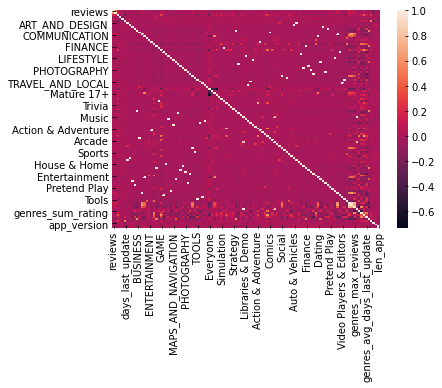

In [75]:
sns.heatmap(dftrain[cols_train].corr())

### Validation

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression

In [77]:
X_train, y_train = dftrain.loc[:, cols_train], dftrain.loc[:,"rating"]
X_test = dftest.loc[:, cols_train]

In [ ]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
std_scaler = RobustScaler()
X_train_encode = std_scaler.fit_transform(X_train[cols_train])
X_train_encode = pd.DataFrame(X_train_encode)
# X_train_encode.columns = cols_train
X_train_encode.index = y_train.index

X_test_encode = std_scaler.transform(X_test[cols_train])
X_test_encode = pd.DataFrame(X_test_encode)
# X_test_encode.columns = cols_train

In [142]:
from sklearn.metrics import f1_score, f1_score
from sklearn.metrics import log_loss

In [ ]:
dftrain.rating.value_counts()

In [83]:
%%time
#### xgboost

model_xgb = xgb.XGBClassifier(objective = 'binary:logistic', 
                              learning_rate = 0.001, n_estimators = 1500, 
                              max_depth = 5,  reg_alpha = 0.2, 
                              booster  = "gbtree", importance_type = "gain")

model_xgb.fit(X_train[cols_train], y_train, verbose = True)
y_pred_xgb_probs = model_xgb.predict_proba(X_test[cols_train])

Wall time: 4.07 s


(array([271., 117., 105., 186., 262., 278.,  61.,  54., 112.,   2.]),
 array([0.11522913, 0.16554214, 0.21585515, 0.26616815, 0.31648117,
        0.36679417, 0.41710716, 0.4674202 , 0.5177332 , 0.5680462 ,
        0.6183592 ], dtype=float32),
 <BarContainer object of 10 artists>)

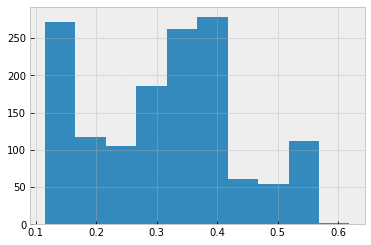

In [84]:
plt.hist(y_pred_xgb_probs[:, 0])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

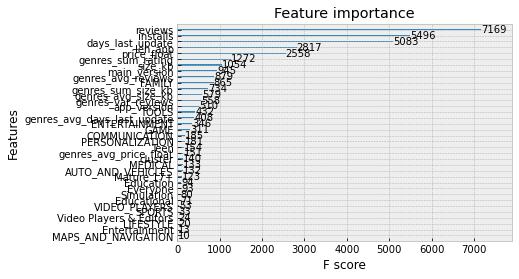

In [85]:
from xgboost import plot_importance
plot_importance(model_xgb)

In [90]:
dfsample["rating"] = np.where(y_pred_xgb_probs[:, 0] > 0.3, 0, 1)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_{}_xgb.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample.rating.value_counts()

0    827
1    621
Name: rating, dtype: int64

In [ ]:
#### lighgbm

In [123]:
# X_test[cols_train].info(verbose = True, null_counts = True)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4317, number of negative: 1471
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1265
[LightGBM] [Info] Number of data points in the train set: 5788, number of used features: 105
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.745853 -> initscore=1.076618
[LightGBM] [Info] Start training from score 1.076618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

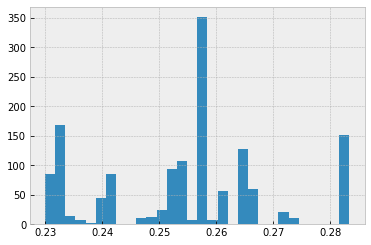

In [104]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(objective ='binary',
    n_estimators = 1000,
    boosting_type='gbdt',
    learning_rate = 0.0001,
    max_depth = 4, 
    verbose = 1, 
    seed = 94)

model_lgb.fit(X_train[cols_train], y_train)
y_pred_lgb_probs = model_lgb.predict_proba(X_test[cols_train])[:, 0]
plt.hist(y_pred_lgb_probs, bins = 30);

In [139]:
dfsample["rating"] = np.where(y_pred_lgb_probs > 0.256, 0, 1)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_{}_lightgbm.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample.rating.value_counts()

0    792
1    656
Name: rating, dtype: int64

In [ ]:
X_test.info()

### Ensamblado

In [143]:
from vecstack import stacking
X_train_col, y_train_col = dftrain.loc[:, cols_train], dftrain.loc[:,"rating"]
X_test_col = dftest.loc[:, cols_train]


models_col = [
            lgb.LGBMClassifier(boosting_type = 'gbdt',
                      learning_rate= 0.001, 
                      n_estimators = 300,
                       objective="binary",
                      max_depth = 3),
    
    XGBClassifier(random_state=0, n_jobs=-1, 
                  learning_rate= 0.002, 
             n_estimators=200, max_depth=3, 
                  objective="binary:logistic"),
    
    XGBClassifier(random_state = 10, 
                  n_jobs=-1, learning_rate=0.001, 
                 n_estimators=250, 
                  max_depth=3, 
                  objective="binary:logistic"),
    
    
    lgb.LGBMClassifier(boosting_type = 'goss',
                      learning_rate= 0.001, 
                      n_estimators = 300, 
                     objective="binary",
                      max_depth = 3)
]


S_train_col, S_test_col = stacking(models_col,                     # list of models
                           X_train_col, y_train_col, X_test_col,   # data
                           regression = False,            # regression task (if you need 
                                                       #     classification - set to False)
                           mode = 'oof_pred',        # mode: oof for train set, predict test 

                           save_dir = None,              # do not save result and log (to save 
                           needs_proba = True,                            #     in current dir - set to '.')
                           metric = log_loss, # metric: callable
                           n_folds = 3,                  # number of folds
                           shuffle = True,               # shuffle the data
                           stratified=True,
                           random_state = 0,             # ensure reproducibility
                           verbose = 2)                  # print all info

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
mode:         [oof_pred]
n_models:     [4]

model  0:     [LGBMClassifier]
    fold  0:  [0.54203189]
    fold  1:  [0.54104833]
    fold  2:  [0.54261434]
    ----
    MEAN:     [0.54189819] + [0.00064628]
    FULL:     [0.54189821]

    Fitting on full train set...

model  1:     [XGBClassifier]
    fold  0:  [0.60332203]
    fold  1:  [0.60085250]
    fold  2:  [0.60275168]
    ----
    MEAN:     [0.60230874] + [0.00105571]
    FULL:     [0.60230891]

    Fitting on full train set...

model  2:     [XGBClassifier]
    fold  0:  [0.62981107]
    fold  1:  [0.62795619]
    fold  2:  [0.62908893]
    ----
    MEAN:     [0.62895206] + [0.00076341]
    FULL:     [0.62895221]

    Fitting on full train set...

model  3:     [LGBMClassifier]
    fold  0:  [0.54203189]
    fold  1:  [0.54104833]
    fold  2:  [0.54261434]
    ----
    MEAN:     [0.54189819] + [0.00064628]
    FULL:     [0.54189821]

    Fitting on ful

In [152]:
y_pred_col_stack  = S_test_col.max(axis = 1)

In [153]:
y_pred_col_stack

array([0.68145631, 0.72830972, 0.68145631, ..., 0.81176497, 0.68145631,
       0.76133442])

In [160]:
dfsample["rating"] = np.where( y_pred_col_stack> 0.65, 1, 0)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_{}_logistic.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample.rating.value_counts()

1    1448
Name: rating, dtype: int64

### Logistic regression

In [ ]:
for col_ in cols_train:
    plt.title(col_)
    plt.hist(np.log1p(X_train[col_]))
    plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
### log
cols_for_lr = ["installs", "size_kb", "genres_max_reviews", 
               "genres_avg_size_kb", "genres_avg_days_last_update"]

lg_model = LogisticRegression()
lg_model.fit(np.log1p(X_train[cols_for_lr]), y_train)
y_pred_lr = lg_model.predict_proba(np.log1p(X_test[cols_for_lr]))[:, 0]
plt.hist(y_pred_lr)

In [ ]:
dfsample["rating"] = np.where(y_pred_lr > 0.25, 0, 1)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_{}_logistic.csv".format(datetime.now().strftime("%Y%m%d")), index=False)

In [ ]:
dfsample.rating.value_counts()

### neural net

In [ ]:
import tensorflow as tf
from keras import losses
from keras import metrics
from keras import optimizers

In [ ]:
from sklearn.model_selection import train_test_split

X_train_partial, X_valid, y_train_partial, y_valid = train_test_split(X_train_encode, y_train,
                                                                      test_size = 0.3, 
                                                                      random_state = 94, 
                                                                      stratify = y_train)

In [ ]:
num_epochs = 500
batch_size = 128 

model_total = tf.keras.Sequential()
model_total.add(tf.keras.Input(shape = (57, ), name="input_red"))
model_total.add(tf.keras.layers.Dense(256, activation = 'relu'))
model_total.add(tf.keras.layers.Dense(128, activation='relu') )
model_total.add(tf.keras.layers.Dense(64, activation='relu'))
model_total.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

model_total.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
                        loss = 'binary_crossentropy',  
                        metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
model_total.fit(X_train_encode.to_numpy(), 
              y_train.to_numpy(), 
              epochs = num_epochs, 
              batch_size = batch_size,
              validation_data = (X_valid, y_valid),
              verbose = 1)

In [ ]:
y_pred_total = model_total.predict(X_test_encode)
plt.hist(y_pred_total)

In [ ]:
y_pred_net = model_total.predict(X_test_encode)
dfsample["rating"] = np.where(y_pred_net > 0.9, 1, 0)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_{}_net.csv".format(datetime.now().strftime("%Y%m%d")), index=False)

In [ ]:
dfsample.rating.value_counts()

In [ ]:
y_pred_net

In [ ]:
pred_probs = (1 - y_pred_net.ravel() + y_pred_lr + y_pred_lgb_probs + y_pred_xgb_probs[:, 0] )/4
plt.hist(pred_probs)

In [ ]:
pred_probs
dfsample["rating"] = np.where(pred_probs > 0.3, 0, 1)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_{}_stck.csv".format(datetime.now().strftime("%Y%m%d")), index=False)
dfsample.rating.value_counts()

In [ ]:
dfsample["rating"] = np.where(y_pred_col_stack>0.76,1, 0)
dfsample.columns = ["id", "rating"]
dfsample[["id", "rating"]].to_csv("datasets/submission_18102019_stack.csv", index=False)

In [ ]:
dfsample["rating"] = np.where(preds_col>0.7, 1, 0)
dfsample.columns = ["id", "rating"]

dfsample[["id", "rating"]].to_csv("datasets/submission_18102019_xgb_07.csv", index=False)

In [ ]:
plt.hist(preds_col)

In [ ]:
dfsample.rating.value_counts()

### Sending submission

In [ ]:
X_train, y_train = dftrain[cols_train], dftrain.price
X_test = dftest[cols_train]

In [ ]:
y_train.min()

In [ ]:
reg_alpha_sys =  0.2
max_depth_sys = 4
n_estimators_sys = 3000
learning_rate = 0.02

params = {
'reg_alpha': reg_alpha_sys,
'max_depth': max_depth_sys,
'n_estimators': n_estimators_sys,
'learning_rate': learning_rate,
'objective': "reg:squarederror",
'modelo': "xgboost",
'silent':1
}


train_dmatrix = xgb.DMatrix(data = X_train[cols_train], label = y_train)
test_dmatrix = xgb.DMatrix(data = X_test[cols_train])


# param = {'max_depth':4, 'eta':1,  'objective':'reg:squarederror' }
num_round = 3000

bst = xgb.train(params, train_dmatrix, num_round, feval = rmsle)

y_pred = bst.predict(test_dmatrix)

In [ ]:
# getFeatureImportance(bst, X_train, "asd")

### Stacking of lisghtgbm

In [ ]:
X_train, y_train = dftrain[cols_train], dftrain.price
X_test = dftest[cols_train]

In [ ]:
models = [
    lgb.LGBMRegressor(boosting_type = 'dart',n_estimators = 3000, max_depth = 3),

    XGBRegressor(random_state=0, n_jobs=-1, learning_rate= 0.02, 
             n_estimators=3000, max_depth=3, objective="reg:squarederror"),
    
    XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                 n_estimators=3000, max_depth=3, objective="reg:squarederror")
]

In [ ]:
X_train, y_train = dftrain[cols_train], dftrain.price
X_test = dftest[cols_train]

models = [
    lgb.LGBMRegressor(boosting_type = 'dart',n_estimators = 3000, max_depth = 3),

    XGBRegressor(random_state=0, n_jobs=-1, learning_rate= 0.02, 
             n_estimators=3000, max_depth=3, objective="reg:squarederror"),
    
    XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.1, 
                 n_estimators=3000, max_depth=3, objective="reg:squarederror")
]


S_train, S_test = stacking(models,                     # list of models
                           X_train, y_train, X_test,   # data
                           regression=True,            # regression task (if you need 
                                                       #     classification - set to False)
                           mode='oof_pred_bag',        # mode: oof for train set, predict test 
                                                       #     set in each fold and find mean
                           save_dir=None,              # do not save result and log (to save 
                                                       #     in current dir - set to '.')
                           metric = mean_squared_error, # metric: callable
                           n_folds=4,                  # number of folds
                           shuffle = True,               # shuffle the data
                           random_state=0,             # ensure reproducibility
                           verbose=2)                  # print all info

In [ ]:
1

In [ ]:
model = XGBRegressor(random_state=0, n_jobs=-1, learning_rate=0.01, 
                     n_estimators=200, max_depth=3)
    
# Fit 2nd level model
model = model.fit(S_train, y_train)

# Predict
y_pred = model.predict(S_test)
y_pred = np.round(y_pred, 0)
# Final prediction score
# print('Final prediction score: [%.8f]' % mean_absolute_error(y_test, y_pred))

### Linear regression

In [ ]:
ln = LinearRegression(normalize = True)
ln.fit(X_train[cols_train], y_train)
preds_ln = ln.predict(X_test[cols_train])
preds_ln = preds_ln

preds_ln = np.where(preds_ln<=0, -1*preds_ln, preds_ln)

In [ ]:
y_pred.max()

In [ ]:
S_test.mean(axis = 1)

In [ ]:
X_test.shape

In [ ]:
# X_test["price"] = (preds_ln + y_pred)/2
# X_test["price"] = y_t
# y_preds = np.where(preds_ln>60000, preds_ln, y_pred)

X_test["pred"] = S_test.mean(axis = 1)
# y_preds*2
X_test["xgboost_pred"] = y_pred
X_test["lineal_pred"] = preds_ln

In [ ]:
dfsample["price"].describe()

In [ ]:
dfsample["price"].describe()

In [ ]:
dftrain.price.min()

In [ ]:
dfsample["price"] = np.round(y_pred,0)
dfsample[["Id", "price"]].to_csv("datasets/submission_24072020_v10.csv", index=False)
# (X_test["pred"].values + y_pred)/2
# dfsample["xgboost"] = y_pred

In [ ]:
dfsample.sort_values("price", ascending = False)

In [ ]:
dfsample[dfsample.price<0]  = np.round(dfsample.price.mean(), 0)

In [ ]:
dfsample.to_csv("datasets/submission_18072020.csv", index=False)

In [ ]:
def rmsle(predictions, dmat):
    labels = dmat.get_label()
    diffs = numpy.log(predictions + 1) - numpy.log(labels + 1)
    squared_diffs = numpy.square(diffs)
    avg = numpy.mean(squared_diffs)
    return ('RMSLE', numpy.sqrt(avg))